# BAYa class Assignment 2021

In this assignment, your task will be to implement and analyze algorithms for inference in probabilistic
models described by factor graphs. In particular, you will implement Sum-Product algorithm (or Belief Propagation), Max-Product (Max-Sum) algorithm and Loopy Belief Propagation to infer different probabilities, (marginal) distributions and values of variables for general factor
graphs with categorical random variables as described in the slides on [Graphical Models and Inference](http://www.fit.vutbr.cz/study/courses/BAYa/public/prednasky/2-Graphical%20Models.pdf).
More detailed information can be found in Chapter 8.4 in [Christopher M. Bishop. 2006. Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

The preferred and easiest way of accomplishing this task is to complete this Jupyter Notebook, which already comes
with a definition of the probabilistic model that you will work with.
If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda3,
run Jupyter Notebook and open this notebook downloaded from [BAYa_Assignment2021.ipynb](http://www.fit.vutbr.cz/study/courses/BAYa/public/notebooks/BAYa_Assignment2021.ipynb).

The following cell contains a code with the definition of the probabilistic model for which you will run the inference algorithms. You should not edit this part!

In [10]:
import numpy as np

#Names of random variables in our model
var_names=['State', 'Age', 'COVID', 'Party', 'Favorite', 'Voting']
           
#Names of possible values (categories) for each random variables.
val_names=[['Texas', 'California', 'NewYork'], #State
           ['Young', 'Old'],                   #Age
           ['Negative', 'Positive'],           #COVID
           ['Democrats', 'Republicans'],       #Party
           ['Biden', 'Trump'],                 #Favorite
           ['InPerson', 'Postal', 'NotVoting']]#Voting

#The above variables with names are introduced just to make up a story around our model. Use these names
# to interpret your results, but, in your 'generic' inference algorithms, avoid the use of these variables
# and use only the definitions below!

#Number of categories for each random variable.
ncategories = np.array([len(v) for v in val_names])

class Factor:
    """
    Instances of this class represent individual factors in a factor graph.
    It is merely a structure of two member variables:
    'vars': list of N integers, which are IDs of N random variables that this
        factor depends on. These integers can be seen as indices into 'var_names'
    'table': potential function of the factor. Since we deal only with categorical
        variables, the potential function has the form of an N-dimensional array.
        The first dimension corresponds to the first variable in 'vars', the second
        dimension to the second variable, etc. The size of each dimension is given
        by the number of possible values of the corresponding variable.
    """
    def __init__(self, list_of_variable, potential_function_table):
        self.vars = list(list_of_variable)
        self.table = np.array(potential_function_table)
        
        # the number of table dimensions and the number of variables must match
        assert(self.table.ndim == len(self.vars))
        # the individual dimensions must match with the number of categories of the corresponding variable
        assert(np.all(ncategories[self.vars]==self.table.shape))

    def __repr__(self):
        # An instance of Factor prints/shows as list of variables (both names and IDs) it depends on  
        return "f("+','.join([var_names[v]+str(v) for v in self.vars])+")"
        
        
"List of factors defining our complete probabilistic model"
factors = [
#         P(State)
    Factor([0], [0.3,   # Texas
                 0.5,   # California
                 0.2]), # NewYork

#         P(Age)
    Factor([1], [0.6,   # Young
                 0.4]), # Old

#         P(COVID)
    Factor([2], [0.7,   # Negative
                 0.3]), # Positive
    

#                               Texas      California  NewYork
#         P(Party|State,Age)   Young,Old   Young,Old   Young.Old
    Factor([3,    0,    1],  [[[0.4, 0.2], [0.9, 0.8], [0.8, 0.6]],  # Democrats 
                              [[0.6, 0.8], [0.1, 0.2], [0.2, 0.4]]]),# Republican

#         P(Favorite|Party)    Dem.  Rep.
    Factor([4,       3],     [[0.95, 0.2],  # Biden
                              [0.05, 0.8]]),# Trump
    
#                                Democrats   Republicans
#         P(Voting|Party,COVID) Neg. Pos.  Neg. Pos. 
    Factor([5,     3,    2], [[[0.5, 0.0], [0.7, 0.1]], # InPerson 
                              [[0.4, 0.9], [0.1, 0.4]], # Postal
                              [[0.1, 0.1], [0.2, 0.5]]])# None
]

In the above cell, we first introduce names of our random variables and their values to make up some "story" around our probabilistic model. Our model "pretends" to model the behaviour of a random US citizen during last year's US presidential elections. It contains the following random variables and their categorical values:

* State: Does the random person come from 'Texas', 'California' or 'NewYork'? For simplicity, we pretend that the USA does not have more states.  
* Age: Is the person 'Young' or 'Old'?
* COVID: Is the person COVID 'Positive' or 'Negative'?
* Party: Is the person a supporter of 'Democrats' or 'Republicans'?
* Favorite: Is the person's preferred presidential candidate 'Biden' or 'Trump'?
* Voting: Is the person voting 'InPerson', using 'Postal' vote or 'NotVoting' at all?

Next came the definition of the full model as a list of factors. In our model, the factors are taken from a bayesian network (see below). Therefore, each factor represents a (normalized) probability distribution for one of the 6 variables. Such variables are always the first element of 'vars' (see 'vars' in class Factor). If 'vars' has more than
one element, then the factor represents a conditional distribution that is conditioned on the remaining variables.

The following function 'evaluate_factor' can help us interpret the individual factors. Its arguments are a Factor  instance and values for all the variables that the factor depends on (in the order given by 'vars'). The values are given only as integer IDs of the categories (i.e. second indices into 'val_names') The function evaluates the factor using the values. Finally, using the variable and value names, it prints out a string showing what (conditional) distribution is evaluated using what values and what is the resulting probability.

In [11]:
def evaluate_factor(factor, *values):
    var_vals = [var_names[var]+'='+val_names[var][val] for var,val in zip(factor.vars, values)]
    print("P("+var_vals[0]+ ('' if len(var_vals)<2 else '|')+(','.join(var_vals[1:]))+") =", factor.table[values])

evaluate_factor(factors[5], 1, 0, 1)
evaluate_factor(factors[5], 2, 1, 1)
evaluate_factor(factors[4], 0, 1)
evaluate_factor(factors[0], 1)

P(Voting=Postal|Party=Democrats,COVID=Positive) = 0.9
P(Voting=NotVoting|Party=Republicans,COVID=Positive) = 0.5
P(Favorite=Biden|Party=Republicans) = 0.2
P(State=California) = 0.5


From the examples of evaluated factors above, we can see that
* 90% of COVID positive supporters of Democrats choose to vote using postal votes
* 50% of COVID positive Republicans choose not to vote at all
* 15% of Republicans find Biden to be more acceptable president
* 40% of voters are from California

Using all the factors, the following code constructs a graph showing the corresponding Bayesian Network. Each node is one variable. For each factor, we create edges into the first variable in 'vars' from all the remaining variables.

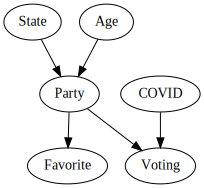

In [12]:
from graphviz import Digraph
dot = Digraph()
dot.edges([(var_names[v] ,var_names[f.vars[0]]) for f in factors for v in f.vars[1:]])
dot

As we can see, our model naively assumes that the probability of being COVID positive does not dependent
on the age or the state the person is from.

Similarly, we can draw Factor Graph corresponding to our model:

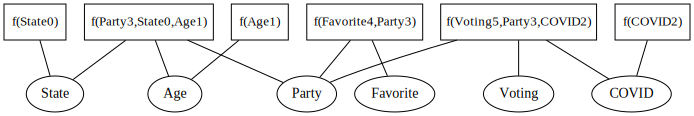

In [13]:
from graphviz import Graph
fg = Graph()
for f in factors:
    #fg.node(var_names[f.vars[0]]+"_", var_names[f.vars[0]]+" "+str(f), shape="box")
    fg.node(var_names[f.vars[0]]+"_", str(f), shape="box", fontsize="13")
fg.edges([(var_names[f.vars[0]]+"_" ,var_names[v]) for f in factors for v in f.vars])
fg

The factor (rectangle) node names are shown in the form as provided by Factor.\__repr__() method. Therefore, whenever printing or viewing an instance of a factor node (e.g. for debugging), it will appear in this form of list of variables (both names and IDs) that the factor depends on. This Factor Graph has tree structure so application of Belief Propagation should be straightforward.

The following cell implements the inefficient 'brute-force marginalization' approach, which will be useful for testing  correctness of your Belief Propagation implementation. When calling this function, we can specify values of some of the variables and the function marginalizes over all possible values of the remaining variables. It implements the operation
 $$
\DeclareMathOperator{\xx}{\mathbf{x}}
\sum_{\xx_{marg}}\prod_s f_s(\xx_s)
$$
where the product is over all factors $f_s$, $\xx_s$ is the subset of variables that $f_s$ depends on and $\xx_{marg}$ is the subset of variables for which the sum sums over all their possible values (i.e marginalizes). As was already said, in our model, each factor corresponds to the (conditional) distribution of one variable. Therefore, their product corresponds to the joint distribution of all the variables
$$
\prod_s f_s(\xx_s) = P(State) P(Age) P(COVID) P(Party|State,Age) P(Favorite|Party) P(Voting|Party,COVID)\\
= P(State,Age,COVID,Party,Favorite,Voting)
$$

For example, if we supply the function with values for $Party$ and $Voting$ and marginalize over all other variables, we obtain the joint marginal probability


$$
P(Party,Voting)=\sum_{State} \sum_{Age}\sum_{COVID}\sum_{Favorite}P(State,Age,COVID,Party,Favorite,Voting)
$$

In [14]:
import itertools    
def brute_force_marginalize(value_list):
    """
    observed_values is a list of values one for each variable. For values set to None,
    we marginalize over all possible values of the corresponding variable. For other
    values, we use the given value for the corresponding variables when evaluating factors.
    """
    value_ranges = [range(n) if v is None else (v,) for n,v in zip(ncategories, value_list)]
    marginal_prob = 0.0
    # itertools.product let us iterate over all possible values of all variables
    for values in itertools.product(*value_ranges):
        joint_prob = 1.0
        for f in factors:
           joint_prob *= f.table[tuple(values[v] for v in f.vars)]
        marginal_prob+=joint_prob
    return marginal_prob

print("Z = ", brute_force_marginalize([None, None, None, None, None, None]))

Z =  0.9999999999999999


When calling **brute_force_marginalize** in the cell above, we set the values of all variables to **None**. This instructs the function to sum over all the values of all the variables. The result is 1, which proves that our model represents a well normalized joint distribution. In the following calls, we clamp some of the variables to specific values, which avoids marginalization over those variables.

In [15]:
print("P(Voting=InPerson)  =", brute_force_marginalize([None, None, None, None, None, 0]))
print("P(Voting=Postal)    =", brute_force_marginalize([None, None, None, None, None, 1]))
print("P(Voting=NotVoting) =", brute_force_marginalize([None, None, None, None, None, 2]))
print("P(Party=Democrats)  =", brute_force_marginalize([None, None, None, 0, None, None]))
print("P(Party=Republicans)=", brute_force_marginalize([None, None, None, 1, None, None]))
print("P(Party=Republicans,Voting=InPerson)=", brute_force_marginalize([None, None, None, 1, None, 0]))

P(Voting=InPerson)  = 0.4061000000000001
P(Voting=Postal)    = 0.43120000000000014
P(Voting=NotVoting) = 0.1627
P(Party=Democrats)  = 0.6699999999999997
P(Party=Republicans)= 0.33000000000000024
P(Party=Republicans,Voting=InPerson)= 0.17159999999999995


The above examples show that the marginal probabilities $P(Voting)$ and $P(Party)$ sum to 1 when summed over all their possible values. The marginal distribution $P(Voting)$ tells us what are the probabilities of different forms of voting (InPerson, Postal, NotVoting) and $P(Party=Democrats)$ says that $2/3$ of all the people are Democrats. 

We also evaluate the joint marginal P(Party,Voting) to see that out of all the people, 17.16% are Republicans that came to vote InPerson.

# Simple implementation of Belief Propagation algorithm
As a quick start, here comes a simple implementation of the Belief Propagation (or Sum-Product) algorithm, which infers marginal distribution for only one variable. Your task will be to extend this code in various ways according to the tasks and questions below.

First, from our factor graph, we create a topologically sorted list of arcs going from leaf nodes to a selected root node. This defines the order in which the messages in the belief propagation algorithm needs to be evaluated.

In [16]:
# Obtain list of topologically sorted arcs (paths from the leaves to the root node)
# by recursively calling down_the_tree() function starting from a selected root node
topologically_sorted_arcs=[]
def down_the_tree(to_node, from_node):
    neighbours = to_node.vars if type(to_node) is Factor else [f for f in factors if to_node in f.vars]
    for node in neighbours:
        if node != from_node:
            down_the_tree(node, to_node)
            topologically_sorted_arcs.append((node, to_node))

# We select variable node 5 as the root node
down_the_tree(5, None)

topologically_sorted_arcs

[(f(State0), 0),
 (0, f(Party3,State0,Age1)),
 (f(Age1), 1),
 (1, f(Party3,State0,Age1)),
 (f(Party3,State0,Age1), 3),
 (4, f(Favorite4,Party3)),
 (f(Favorite4,Party3), 3),
 (3, f(Voting5,Party3,COVID2)),
 (f(COVID2), 2),
 (2, f(Voting5,Party3,COVID2)),
 (f(Voting5,Party3,COVID2), 5)]

As we can see, the result of this step is a list of (from_node, to_node) tuples. Each tuple contains one factor node (instance of class Factor) and one variable node (integer ID) saying from which node to which node given arc leads.

Next we define function **evaluate_message(from_node, to_node, message_dict)**, which evaluates message from node **from_node**, to node **to_node** using already evaluated messages stored in dictionary **message_dict** and stores the new message also to dictionary **message_dict**. This function simply implements the two main formulas of the Belief Propagation algorithm:
$$
\mu_{x_m\rightarrow f_s}(x_m) = \prod_{l \in ne(x_m)\setminus f_s} \mu_{f_l\rightarrow x_m}(x_m)
$$
$$
\mu_{f_s\rightarrow x_n}(x_n)=\sum_{\mathbf{x}_s\setminus x_n }f_s(\mathbf{x}_s) \prod_{m \in ne(f_s)\setminus x_n}\mu_{x_m\rightarrow f_s}(x_m)
$$
It selects the right formula depending on the type of the evaluated message (from factor to variable node or the other way around). It also covers the initial values for the leaf nodes where $\mu_{f\rightarrow x}(x)=f(x)$ and $\mu_{x\rightarrow f}(x)=1$.

Next we call **evaluate_message** in a loop to evaluate all the (topologically sorted) messages from the leaves to the selected root.

In [17]:
def evaluate_message(from_node, to_node, message_dict):
    # Message from variable to factor (i.e. the first formula above)
    if type(to_node) is Factor: 
        msg_values=np.ones(ncategories[from_node])
        var_node_neighbours = [f for f in factors if from_node in f.vars] # Find neighbouring factor nodes
        for fac in var_node_neighbours:          # Retrieve messages (vectors) from all neighbour nodes
            if fac != to_node:                              # except for the target factor node
                msg_values *= message_dict[(fac, from_node)]# and calculate their product as the new message.
                
    # Message from factor to variable (i.e. the first formula above)
    else:
        # We need to multiply the messages (vectors) coming from the neighbouring variable nodes to the corresponding
        # dimensions of the factor table and marginalize these dimensions out (i.e. sum over these dimensions).
        # This is done by calling np.tensordot in the code below once for each dimension/message. However,
        # we need to skip the dimension/variable corresponding to the target variable (to_node). To do that,
        # we move this dimension to be the last dimension in the np.array representing the factor table.
        msg_values = np.moveaxis(from_node.table, from_node.vars.index(to_node), -1)
        for var in from_node.vars:                          # Retrieve messages (vectors) from all neighbour nodes
            if var != to_node:                              # except for the target variable node
                msg_values = np.tensordot(msg_values, message_dict[(var, from_node)], axes=([0],[0]))
                                                            # and evaluate the new message (to the target node).
        """"
        # An alternative more explicit implementation of the 'else' branch
        msg_values = np.moveaxis(from_node.table, from_node.vars.index(to_node), 0)
        for var in from_node.vars[::-1]: # Go through the variables (and the incoming messages) in the reverse order. ...
            if var != to_node:
                msg_values = np.sum(msg_values * message_dict[(var, from_node)], axis=-1)
                # ... Then the first message corresponds with the last dimension of 'msg_values'. We multiply
                # the message to the last dimension of 'msg_values' and marginalize (sum) it out. The last dimension
                # disappears and the next message is ready to be multiplied to the new last dimension.
        """
                    
    message_dict[(from_node, to_node)] = msg_values # Store the new message

messages={}
for from_node, to_node in topologically_sorted_arcs:
    evaluate_message(from_node, to_node, messages)
    
messages

{(f(State0), 0): array([0.3, 0.5, 0.2]),
 (0, f(Party3,State0,Age1)): array([0.3, 0.5, 0.2]),
 (f(Age1), 1): array([0.6, 0.4]),
 (1, f(Party3,State0,Age1)): array([0.6, 0.4]),
 (f(Party3,State0,Age1), 3): array([0.67, 0.33]),
 (4, f(Favorite4,Party3)): array([1., 1.]),
 (f(Favorite4,Party3), 3): array([1., 1.]),
 (3, f(Voting5,Party3,COVID2)): array([0.67, 0.33]),
 (f(COVID2), 2): array([0.7, 0.3]),
 (2, f(Voting5,Party3,COVID2)): array([0.7, 0.3]),
 (f(Voting5,Party3,COVID2), 5): array([0.4061, 0.4312, 0.1627])}

As we can see, the result of this step is a dictionary of all the evaluated messages. The keys are the (from_node, to_node) tuples identifying the arcs as before and the values are the corresponding messages (vectors).

Finally, we define function **marginal4var(var, message_dict)**, which evaluates the marginal distribution for variable **var**, using the messages stored in the dictionary **message_dict**. Of course, it is possible only if all the messages necessary to evaluate this distribution are present in the dictionary. In our case, we only evaluated messages leading to the root node corresponding to variable "Voting" (variable ID 5). Therefore, we can call this function only for this node.

In [18]:
def marginal4var(var, message_dict):
    res = np.prod([message_dict[k] for k in message_dict.keys() if k[1] == var], axis=0)
    return res / np.sum(res)

print("P(Voting) =", marginal4var(5, messages),"\n")
print("P(Voting=0)=", brute_force_marginalize([None, None, None, None, None, 0]))
print("P(Voting=1)=", brute_force_marginalize([None, None, None, None, None, 1]))
print("P(Voting=2)=", brute_force_marginalize([None, None, None, None, None, 2]),"\n")


P(Voting) = [0.4061 0.4312 0.1627] 

P(Voting=0)= 0.4061000000000001
P(Voting=1)= 0.43120000000000014
P(Voting=2)= 0.1627 



We can see that calling **marginal4var** for variable "Voting" gives us its correct marginal distribution as verified using function **brute_force_marginalize**.

# Tasks and Questions
Your task is to extend the above code to answer questions in the following points. Please comment your code sufficiently. It will be taken into account when evaluating the project. Describe what, why and how are you trying to implement. Try to reuse the existing code or its structure as much as possible. Please, do not implement complex general classes and functions with lots of parameters and branches trying to address all the problems and answer all the questions. Instead, write simple single purpose streamlined code addressing a single problem at a time. If you need to implement simple modification of already existing function, do not be afraid to copy-paste that function and modify it. Then explain in comments, what modification you did and why. Try to make your code as little cryptic and as easy to follow as possible.


1\. For all the individual variables, use the Sum-Product  algorithm to (most efficiently) infer and print their marginal distributions $P(State)$, $P(Age)$, $P(COVID)$, $P(Party)$, $P(Favorite)$, $P(Voting)$. We already evaluated marginal distributions for variable $Voting$ in the code above where we used functions **evaluate_message** and **marginal4var**. Reuse these functions as they are to evaluate all the marginal distributions. Check their correctness using the **brute_force_marginalize** function.

In [19]:
# Write your code and comments here.
# This should be possible to implement in about 10 lines of code
# Feel free to add more notebook cells (e.g. if you want to write more comments into a Markdown cell)

2\. What is the computational complexity of the inference from the previous point compared to the brute-force marginalization? Extend the code for the inference algorithms (both brute-force and Sum-Product) to count the number of additions and multiplications carried out during the inference (consider only those from the equations describing the algorithm). Report these numbers. Note that, with the brute-force approach you need to call the brute_force_marginalize once for every value of every variable in order to evaluate all the marginal distributions. Note also that single call of **np.tensordot** in function **evaluate_message** performs many multiplications and additions. You need to count all of them. Similarly, when calculating the product of two messages, it is an element-wise product of several numbers.

In [20]:
# Write your code and comments here.

3\. Implement function **jointmarginal4fact** similar to already implemented function **marginal4var**. However, this function gets an instance of Factor as the first parameter and evaluates joint marginal distribution for all the variables that the factor depends on. Use this function to evaluate and print joint marginal distributions $P(Favorite, Party)$ and $P(Voting,Party,COVID)$. Check their correctness using the **brute_force_marginalize** function.


In [21]:
def jointmarginal4fact(fac, message_dict):
    assert(type(fac) is Factor)
    # Write your code and comments here.

4\. Implement Max-Product (or Max-Sum) algorithm and use it to infer the most likely setting of all the variables. In other words, find the values for all the variables that maximizes the joint probability $P(State, Age, COVID, Party, Favorite, Voting)$. For this purpose, implement and use function **evaluate_maxproduct_message** similar to already implemented function **evaluate_message**, where sumations (hidden in **np.tensordot**) needs to be replaced by max operation. Note that this is somewhat tricky task and, before introducing the max operation, you may want to first reimplement **evaluate_message** so that **np.tensordot** is reimplemented using nested 'for' loops. The function also needs to store the the information necessary for backtracking. Use the parameter **backtrack_dict** for this purpose. To find the most likely setting of the variables, you will call **evaluate_maxproduct_message** only for messages sent from leaves to a selected variable root node. Then you can evaluate the most likely setting of the root node and backtrack the most likely values of the other variables as described in the [slides](http://www.fit.vutbr.cz/study/courses/BAYa/public/prednasky/2-Graphical%20Models.pdf).

In [22]:
def evaluate_maxproduct_message(from_node, to_node, message_dict, backtrack_dict):
    assert(type(from_node) is Factor and type(to_node) is int or type(from_node) is int and type(to_node) is Factor)
    # Write your code and comments here.
    # backtrack_dict does not have to be dictionary if you prefer to store the backtracking information another way.


5\. Implement function **brute_force_one_best** which finds the most likely setting of all variables using the bruteforce approach (i.e. by evaluating joint probability of all variables for all possible settings of the variables). This can be easily achieved by modifying/simplifying function **brute_force_marginalize**. Use this function to check that your implementation of the  Max-Product algorithm is correct. How does the most likely setting of all variables compare to the most likely values according to marginal distributions of the individual variables?

In [23]:
def brute_force_one_best():
    pass # Write your code and comments here.

6\. In the following code cell, we change our factor graph by redefining the factors corresponding to the distributions for variables $Age$ and $COVID$. These factors will now represent conditional distributions $P(Age|State)$ and $P(COVID|State)$ (i.e. the variables are newly conditioned on variable $State$) to express that the ratios of Old/Young people and COVID positive/negative people are different in different states. Please, display the Bayesian Network and the Factor Graph for this updated model and identify a loop in the Factor Graph to show it does not have a tree structure anymore.

In [24]:
# Do not change this field!

#                  P(Age|State) Texas California NewYork
factors[1] = Factor([1,  0],   [[0.7,    0.5,     0.4], # Young
                                [0.3,    0.5,     0.6]])# Old

#                  P(COVID|State) Texas California NewYork
factors[2] = Factor([2,    0],   [[0.55,     0.7,     0.6], # Negative
                                  [0.45,     0.3,     0.4]])# Positive

#ATTENTION! After executing this code, you need to invalidate/recalculate variables like 'topologically_sorted_arcs'
# or 'messages' as they contain references to the old (now invalid) factor instances.

In [26]:
# Write your code and comments here.

7\. Since the Factor Graph is not a tree, we cannot use the standard Belief Propagation algorithm for the inference. Therefore, use Loopy Belief Propagation algorithm to infer all marginal distributions $P(State)$, $P(Age)$, $P(COVID)$, $P(Party)$, $P(Favorite)$, $P(Voting)$ for the updated model. Again, reuse the existing functions **evaluate_message** and **marginal4var** and check the correctness of the inferred distributions using the **brute_force_marginalize** function. Note that, because of the loop in the Factor Graph, the message cannot be topologically sorted and an alternative iterative schedule needs to be chosen for evaluating the messages. What schedule for evaluating the messages did you choose? How does it affect the convergence of the algorithm? Note that, to increase numerical stability of the Loopy Belief Propagation algorithm, it is good a idea to normalize each message so that it sums to 1. Such normalization does not change the result.

In [27]:
# Write your code and comments here.

8\. For our updated model, infer the most likely setting of all the variables using the brute-force approach Use the already implemented **brute_force_one_best** function for this purpose. Note that "loopy variant" of the Max-Product algorithm can be also used for this purpose. You might try to implement it and experiment with it to gain some bonus points.

In [28]:
# Write your code and comments here.